In [1]:

# test activated or not
def is_acti(acti_lst,cord):
    flag = 0
    for block in acti_lst:
        ac_y_cor = (block-1)//4
        ac_x_cor = (block-1)%4
        x_l = 1/6*(1+ac_x_cor)
        x_h = 1/6*(2+ac_x_cor)
        y_l = 1/6*(1+ac_y_cor)
        y_h = 1/6*(2+ac_y_cor)
        if cord[0] >= x_l and cord[0] <= x_h and cord[1] >= y_l and cord[1] <= y_h:
            flag = 1
    return flag
# Define the grid size N

import numpy as np
import matplotlib.pyplot as plt

def relax(u, f,  nu, dx,omega,method):
    assert method == 'GS' or method == 'Jacobi'
    N = u.shape[0]
    u_new = np.copy(u)
    for _ in range(nu+1):
        for i in range(1, N - 1):
            for j in range(1, N - 1):
                #u_new[i, j] = 0.25 * (u[i - 1, j] + u[i + 1, j] + u[i, j - 1] + u[i, j + 1] - h * h * f[i, j])
                if method == 'Jacobi':
                    u_new[i, j] = (1 - omega) * u[i, j] + (omega / 4) * (
                    u[i + 1, j] + u[i - 1, j] + u[i, j + 1] + u[i, j - 1] + f[i,j]*(dx**2)) 
                if method == 'GS':
                    u_new[i, j] = (1 - omega) * u[i, j] + (omega / 4) * (
                    u[i + 1, j] + u_new[i - 1, j] + u[i, j + 1] + u_new[i, j - 1] + f[i,j]*(dx**2)) 
        u, u_new = u_new, u
    return u
        
        
def restrict(r):
    
    N = r.shape[0]
    Nc = N  // 2
    rc = np.zeros((Nc, Nc))
    for i in range(1, Nc - 1):
        for j in range(1, Nc - 1):
            #rc[i, j] = 0.25 * (r[2 * i, 2 * j] + r[2 * i + 1, 2 * j] + r[2 * i, 2 * j + 1] + r[2 * i + 1, 2 * j + 1])
            rc[i,j] = r[2*i,2*j]
    
    return rc

def calc_res(f,u,dx):
    N = f.shape[0]
    u_res = np.zeros((N+1, N+1))
    for i in range(1, N - 1):
        for j in range(1, N - 1):
            #u_res[i,j] = f[i,j] + (4*u[i, j] -  (u[i - 1, j] + u[i + 1, j] + u[i, j - 1] + u[i, j + 1] ) )/(h**2)

            u_res[i,j] = (-u[i, j] + (1 / 4) * (
            u[i + 1, j] + u[i - 1, j] + u[i, j + 1] + u[i, j - 1] + f[i,j]*(dx**2)) ) / (0.25*dx**2)
    return u_res

    
def interpolate(e):
    Nc = e.shape[0]
    N = 2 * Nc 
    ef = np.zeros((N+1, N+1))
    for i in range(1, N ):
        for j in range(1, N ):
            ef[i, j] = e[i // 2, j // 2]
    return ef

def test_error_multi( u, f ,u_exact , h, nu1, nu2, nuc, iteration,N,omega,method,fig,ax):
    u_temp = np.copy(u)
    diff = []
    for iteri in range(iteration):
        # Relaxation with initial guess
        u1_3 = relax(u_temp, f,  nu1, h,omega,method)
         

        # Compute residual and restrict
        #r = f - (A.reshape(((N+1)**2,(N+1)**2)) .dot( u1_3.reshape((N+1)**2))).reshape((N+1,N+1))
        r = calc_res(f,u1_3,h)
        rc = restrict(r)

        #print('r',np.linalg.norm((r).reshape((r.shape[0])**2), ord=2))
        #print(rc)
        # Coarse grid correction
        #eh = np.linalg.solve(A_res.reshape(((N//2)**2,(N//2)**2)), rc.reshape((N//2)**2)).reshape((N//2,N//2))
        eh = relax(np.zeros(((N ) // 2,(N ) // 2)), rc,  nuc, 2*h,omega,method)
        # Prolongate and correct
        e = interpolate(eh)
        u2_3 = u1_3 + e  ##############

        # Relaxation with corrected guess
        u_temp = relax(u2_3, f,  nu2, h,omega,method)
        diff.append(np.linalg.norm((u_temp-u_exact).reshape((N+1)**2), ord=2))

    ax.plot(range(iteration),diff,label='omega = '+str(round(omega,1)))
        


SyntaxError: unexpected EOF while parsing (2713987074.py, line 97)

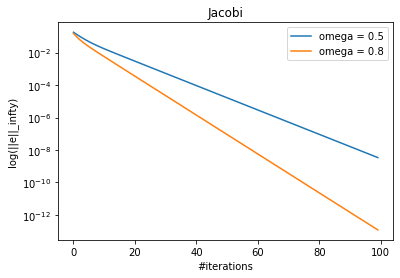

In [ ]:


# Set up your grid, boundary conditions, and f (right-hand side)
method = 'Jacobi'

N = 25 - 1
dx = 1.0 / N
u = np.zeros((N+1, N+1))
f = np.zeros((N+1, N+1))
act_lst = [1,7,14,16]
for i in range(0,N+1):
    for j in range(0,N+1):
        if is_acti(act_lst,(i*dx,j*dx)):
        #if i<2:
            f[i,j] = 1

A = np.zeros((N + 1, N + 1, N + 1, N + 1))
for i in range(0, N+1):
    for j in range(0, N+1):
        A[i,j,i,j] = 1
        if i in range(1, N) and j in range(1, N):
            A[i,j,i+1,j] = -0.25
            A[i,j,i-1,j] = -0.25
            A[i,j,i,j+1] = -0.25
            A[i,j,i,j-1] = -0.25
            
A_vec = A.reshape(((N+1)**2,(N+1)**2))
f_vec = f.reshape((N+1)**2)*0.25*dx**2
u_vec = np.linalg.inv(A_vec).dot(f_vec)
u_exact = u_vec.reshape((N+1,N+1))            


# Number of iterations for relaxation
nu1 = 1
nu2 = 1
nuc = 20
iteration = 100


fig, ax = plt.subplots()
# Perform a two-grid cycle
test_error_multi(u, f, u_exact, dx,nu1, nu2, nuc, iteration,N,0.5,method,fig=fig,ax=ax)
test_error_multi(u, f, u_exact, dx,nu1, nu2, nuc, iteration,N,0.8,method,fig=fig,ax=ax)





# Plot the solution

ax.set_yscale('log')
ax.set_title("Jacobi")
ax.set_xlabel("#iterations")
ax.set_ylabel("log(||e||_infty)")
ax.legend()
plt.show()

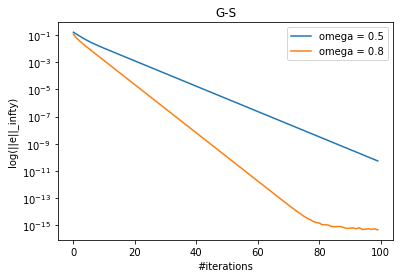

In [ ]:


# Set up your grid, boundary conditions, and f (right-hand side)
method = 'GS'

N = 25 - 1
dx = 1.0 / N
u = np.zeros((N+1, N+1))
f = np.zeros((N+1, N+1))
act_lst = [1,7,14,16]
for i in range(0,N+1):
    for j in range(0,N+1):
        if is_acti(act_lst,(i*dx,j*dx)):
        #if i<2:
            f[i,j] = 1

A = np.zeros((N + 1, N + 1, N + 1, N + 1))
for i in range(0, N+1):
    for j in range(0, N+1):
        A[i,j,i,j] = 1
        if i in range(1, N) and j in range(1, N):
            A[i,j,i+1,j] = -0.25
            A[i,j,i-1,j] = -0.25
            A[i,j,i,j+1] = -0.25
            A[i,j,i,j-1] = -0.25
            
A_vec = A.reshape(((N+1)**2,(N+1)**2))
f_vec = f.reshape((N+1)**2)*0.25*dx**2
u_vec = np.linalg.inv(A_vec).dot(f_vec)
u_exact = u_vec.reshape((N+1,N+1))            


# Number of iterations for relaxation
nu1 = 1
nu2 = 1
nuc = 20
iteration = 100


fig, ax = plt.subplots()
# Perform a two-grid cycle
test_error_multi(u, f, u_exact, dx,nu1, nu2, nuc, iteration,N,0.5,method,fig=fig,ax=ax)
test_error_multi(u, f, u_exact, dx,nu1, nu2, nuc, iteration,N,0.8,method,fig=fig,ax=ax)





# Plot the solution

ax.set_yscale('log')
ax.set_title("G-S")
ax.set_xlabel("#iterations")
ax.set_ylabel("log(||e||_infty)")
ax.legend()
plt.show()

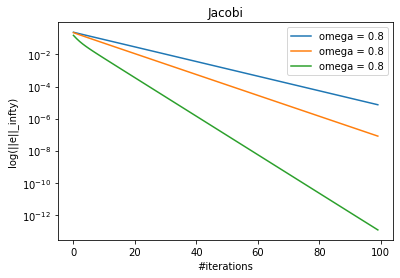

In [ ]:


# Set up your grid, boundary conditions, and f (right-hand side)
method = 'Jacobi'

N = 25 - 1
dx = 1.0 / N
u = np.zeros((N+1, N+1))
f = np.zeros((N+1, N+1))
act_lst = [1,7,14,16]
for i in range(0,N+1):
    for j in range(0,N+1):
        if is_acti(act_lst,(i*dx,j*dx)):
        #if i<2:
            f[i,j] = 1

A = np.zeros((N + 1, N + 1, N + 1, N + 1))
for i in range(0, N+1):
    for j in range(0, N+1):
        A[i,j,i,j] = 1
        if i in range(1, N) and j in range(1, N):
            A[i,j,i+1,j] = -0.25
            A[i,j,i-1,j] = -0.25
            A[i,j,i,j+1] = -0.25
            A[i,j,i,j-1] = -0.25
            
A_vec = A.reshape(((N+1)**2,(N+1)**2))
f_vec = f.reshape((N+1)**2)*0.25*dx**2
u_vec = np.linalg.inv(A_vec).dot(f_vec)
u_exact = u_vec.reshape((N+1,N+1))            


# Number of iterations for relaxation
nu1 = 1
nu2 = 1
nuc = 20
iteration = 100


fig, ax = plt.subplots()
# Perform a two-grid cycle
test_error_multi(u, f, u_exact, dx,nu1, nu2, 2, iteration,N,0.8,method,fig=fig,ax=ax)
test_error_multi(u, f, u_exact, dx,nu1, nu2, 4, iteration,N,0.8,method,fig=fig,ax=ax)
test_error_multi(u, f, u_exact, dx,nu1, nu2, 20, iteration,N,0.8,method,fig=fig,ax=ax)





# Plot the solution

ax.set_yscale('log')
ax.set_title("Jacobi, omega = 0.8")
ax.set_xlabel("#iterations")
ax.set_ylabel("log(||e||_infty)")
ax.legend()
plt.show()

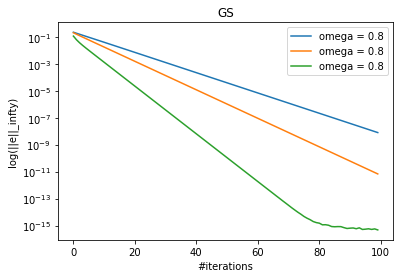

In [ ]:


# Set up your grid, boundary conditions, and f (right-hand side)
method = 'GS'

N = 25 - 1
dx = 1.0 / N
u = np.zeros((N+1, N+1))
f = np.zeros((N+1, N+1))
act_lst = [1,7,14,16]
for i in range(0,N+1):
    for j in range(0,N+1):
        if is_acti(act_lst,(i*dx,j*dx)):
        #if i<2:
            f[i,j] = 1

A = np.zeros((N + 1, N + 1, N + 1, N + 1))
for i in range(0, N+1):
    for j in range(0, N+1):
        A[i,j,i,j] = 1
        if i in range(1, N) and j in range(1, N):
            A[i,j,i+1,j] = -0.25
            A[i,j,i-1,j] = -0.25
            A[i,j,i,j+1] = -0.25
            A[i,j,i,j-1] = -0.25
            
A_vec = A.reshape(((N+1)**2,(N+1)**2))
f_vec = f.reshape((N+1)**2)*0.25*dx**2
u_vec = np.linalg.inv(A_vec).dot(f_vec)
u_exact = u_vec.reshape((N+1,N+1))            


# Number of iterations for relaxation
nu1 = 1
nu2 = 1
nuc = 20
iteration = 100


fig, ax = plt.subplots()
# Perform a two-grid cycle
test_error_multi(u, f, u_exact, dx,nu1, nu2, 2, iteration,N,0.8,method,fig=fig,ax=ax)
test_error_multi(u, f, u_exact, dx,nu1, nu2, 4, iteration,N,0.8,method,fig=fig,ax=ax)
test_error_multi(u, f, u_exact, dx,nu1, nu2, 20, iteration,N,0.8,method,fig=fig,ax=ax)





# Plot the solution

ax.set_yscale('log')
ax.set_title("GS, omega = 0.8")
ax.set_xlabel("#iterations")
ax.set_ylabel("log(||e||_infty)")
ax.legend()
plt.show()